In [0]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras.layers import *
from keras.applications import *
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.optimizers import *
from keras.activations import *
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline

In [0]:
np.random.seed(2019)
tf.set_random_seed(2019)

Linking the Google drive to access data files


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Extracting the Zip into the Tem folder of Colab storage

In [0]:
import os
import zipfile 

local_zip = '/content/drive/My Drive/Hardik/train_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/train_images/')
zip_ref.close()

local_zip = '/content/drive/My Drive/Hardik/test_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/test_images') 
zip_ref.close()

Reading the Images Path

In [0]:
import os
train_dir = os.path.join('/tmp/train_images/')
#test_dir = os.path.join('/tmp/test_images/Test/')
Classes = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}

print('total training images:', len(os.listdir(train_dir)))
#print('total testing images:', len(os.listdir(test_dir)))

total training images: 3662


Dataframe file from CSV format

In [0]:
train_df=pd.read_csv('/content/drive/My Drive/Hardik/train.csv')
#test_df=pd.read_csv('/content/drive/My Drive/Hardik/Test_kappa.csv') #without label column 

If the image type extension is not aleady present in the Image File name, we have to add it manually. This is required by the ImageDataGenerator to work, so make sure that every image its extension name appended.

In [0]:
train_df.id_code = train_df.id_code.apply(lambda x: x + ".png")
#test_df.image[502:605] = test_df.image[502:605].apply(lambda x: x + ".jpg")
#test_df.image[502:605]


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

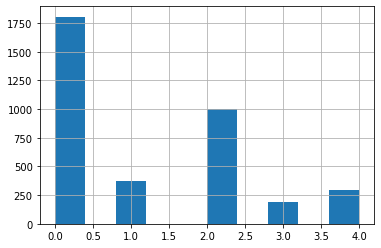

In [0]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

In [0]:
x = train_df['id_code']
y = train_df['diagnosis']

IMG_SIZE = 299
SEED = 77

Showing some images before Preprocessing

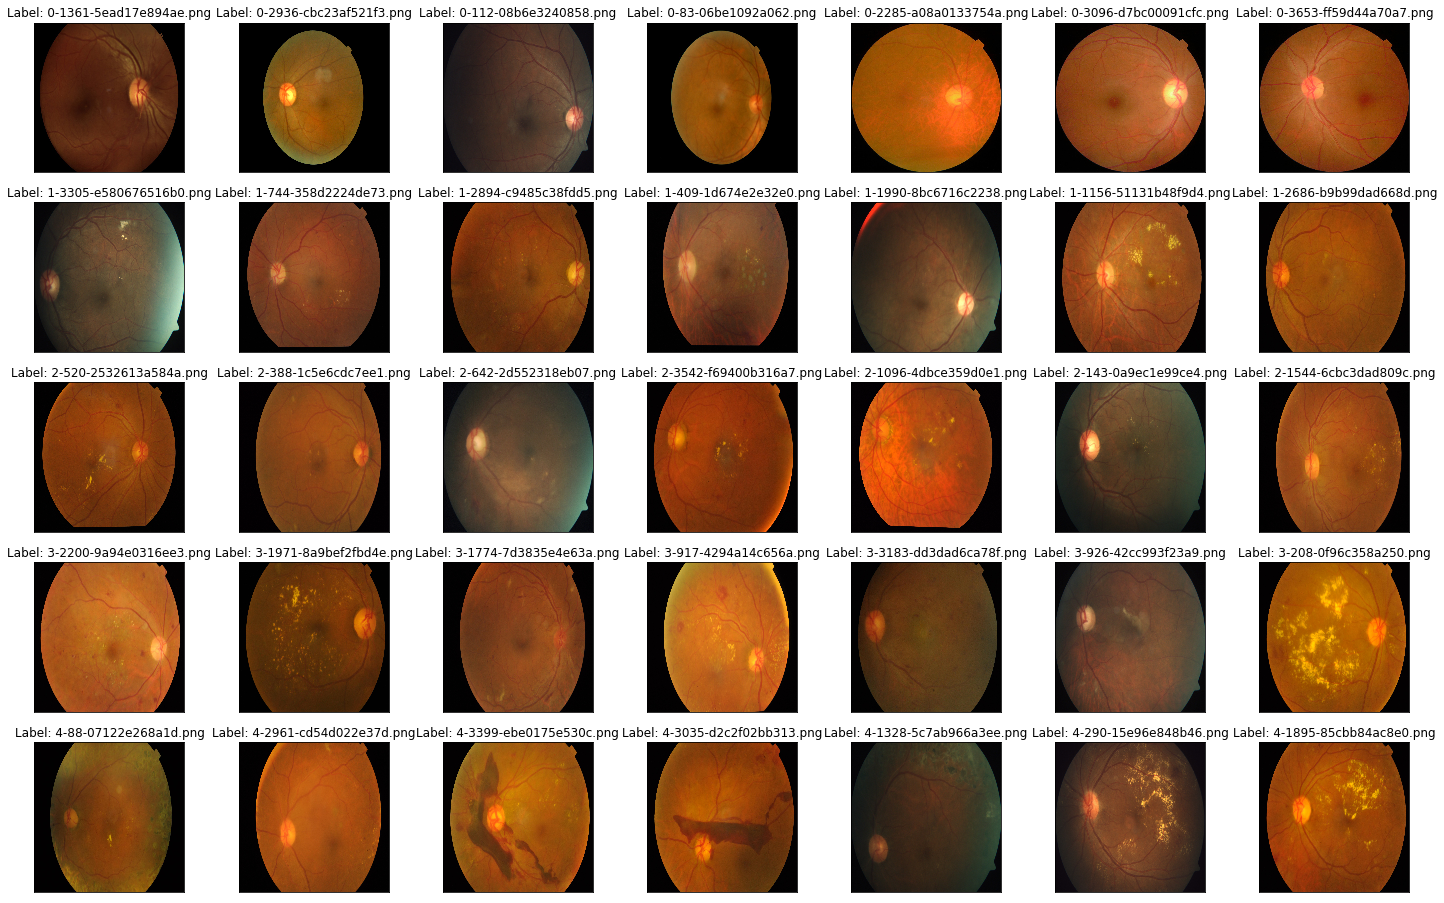

In [0]:
NUM_SAMP = 7

fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y.unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/tmp/train_images/{row['id_code']}"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )
        

Preprocessing method to enhance the features of the DR

In [0]:
#To crop out the uninformative black areas which are evident on pic(0,1), pic(0,3) and pic(4,1), we can try auto cropping.


def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # therefore return back original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
             #print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
             #print(img.shape)
        return img

# Adding Ben Gharam's method who won the 2015 Kaggle competition by preprocessing with GaussianBlur function of openCV

def preprocess_image(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128) #Ben Gharam's method
        
    return image

Now showing the same images after preprocessing

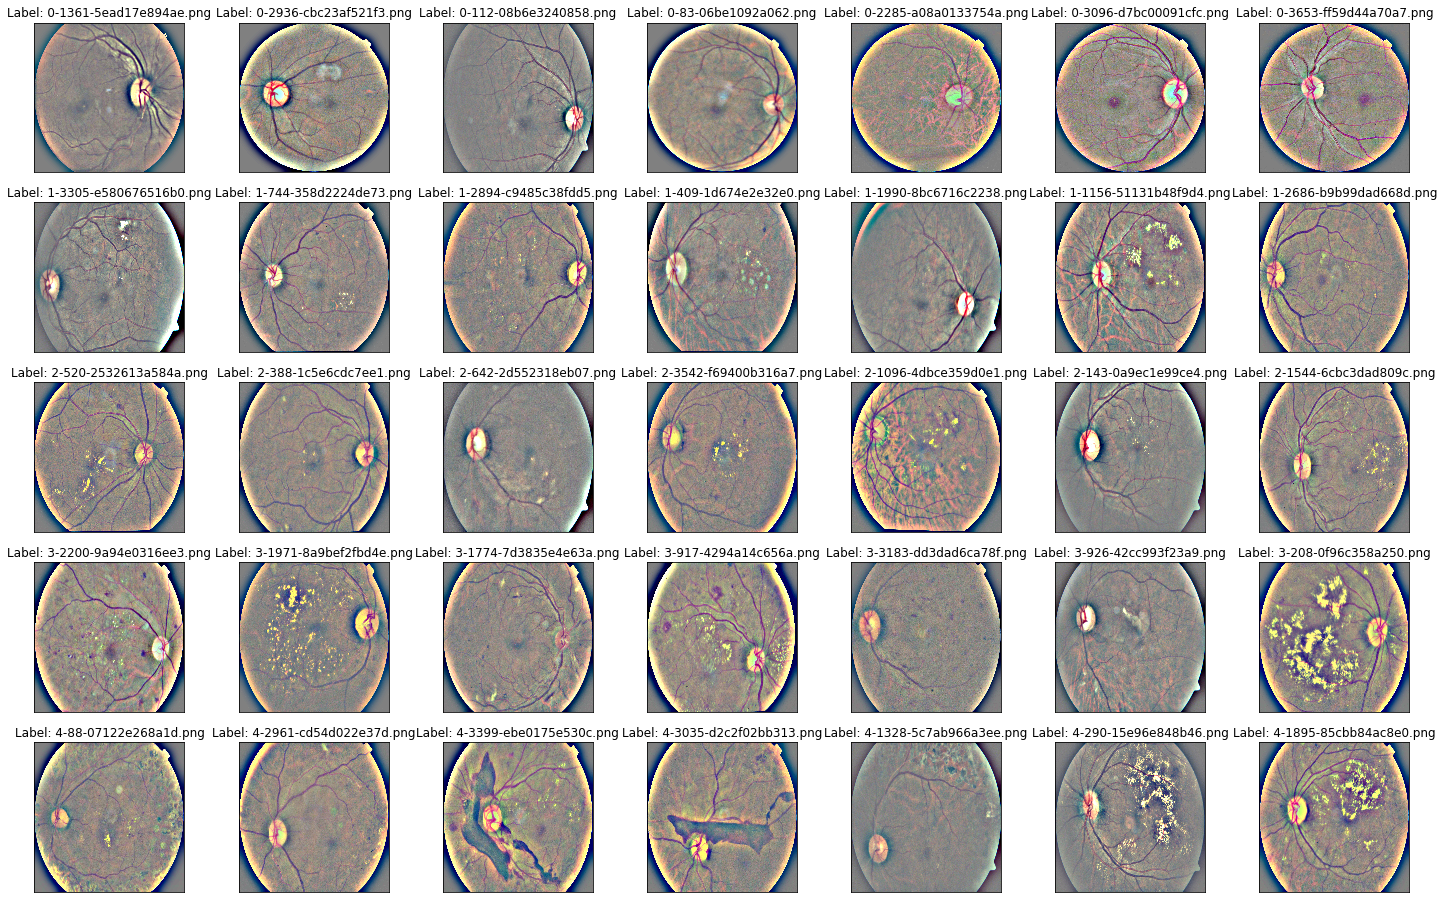

In [0]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y.unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED ).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/tmp/train_images/{row['id_code']}"
        image = preprocess_image(path,sigmaX=10)

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

Calling the preprocesing Method on all the images 

In [0]:
N = train_df.shape[0]
x_train = np.empty((N, 299, 299, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'/tmp/train_images/{image_id}')

100%|██████████| 3662/3662 [09:44<00:00,  5.77it/s]


In [0]:
"""
N = test_df.shape[0]
x_test = np.empty((N, 299, 299, 3), dtype=np.uint8)

for i, image in enumerate(tqdm(test_df['image'])):
    x_test[i, :, :, :] = preprocess_image(f'/tmp/test_images/Test/{image}')
"""    

100%|██████████| 999/999 [02:29<00:00,  6.89it/s]


Now here we are creating the Dummies for each of the class values, i.e each column for each class

In [0]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
#print(x_test.shape)

(3662, 299, 299, 3)
(3662, 5)


Now, we are creating multi lables by performing the logical OR operation on dummy columns and creating a single column for multi variables

In [0]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


This is how labels are represented now in the multilabel column. First array denotes 2nd class, second arrary 4th class and so on,

In [0]:
y_train_multi

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint8)

Splitting the training dataset into Training, Validation and Test set.

In [0]:
#creating test set
x_temp, x_test, y_temp, y_test = train_test_split(x_train, y_train_multi, test_size=0.12, random_state=2019)

#creating training and validation set
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.15, random_state=2019)




Now calling the imagedatagenerator and the augmentations used.

In [0]:
BATCH_SIZE = 16

datagen = ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        shear_range=0.1,
        cval=0., 
        rotation_range=0.2, # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)


Now creating the callback function which works every time the kappa value increases and then the best model weight is saved to the given path

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('/tmp/finetunemodel.h5')

        return

Constructing the CNN architecture on Xception. I am not using the imagenet Weights for transfer learing because Imagenet was not trained on medical images.

So I already trained the Xception model with the following same architecture on a very large dataset of images with all layers unfrozen to get all the features and took the best weights obtained there and using it here. This is basically finetuning the model.

In [0]:
base_model = Xception(
    weights=None,
    include_top=False,
    input_shape=(299,299,3)
)


x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='sigmoid')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output_layer = Dense(5, activation='sigmoid', name="Output_Layer")(x)
model = Model(base_model.input, output_layer)

model.load_weights('/content/drive/My Drive/Hardik/xception_2015.h5')

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In fine tuning we wont train all the layers again, we'll just train the top layers that we added i.e last 5 layers

In [0]:
for layer in model.layers[:-5]:
  layer.trainable = True

I also reduced to learning rate from 0.00005 to 0.000002 to learn more in fine tuning.

In [0]:
model.compile(
        loss='binary_crossentropy',
        optimizer= Adam(lr=0.000002),
        metrics=['accuracy']
    )




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)



Epoch 1/15
172/171 [==============================] - 91s 531ms/step - loss: 0.2004 - acc: 0.9295 - val_loss: 0.1581 - val_acc: 0.9459
val_kappa: 0.8782
Validation Kappa has improved. Saving model.
Epoch 2/15
172/171 [==============================] - 74s 433ms/step - loss: 0.1729 - acc: 0.9396 - val_loss: 0.1518 - val_acc: 0.9455
val_kappa: 0.8792
Validation Kappa has improved. Saving model.
Epoch 3/15
172/171 [==============================] - 74s 432ms/step - loss: 0.1725 - acc: 0.9383 - val_loss: 0.1461 - val_acc: 0.9479
val_kappa: 0.8817
Validation Kappa has improved. Saving model.
Epoch 4/15
172/171 [==============================] - 74s 432ms/step - loss: 0.1677 - acc: 0.9401 - val_loss: 0.1432 - val_acc: 0.9479
val_kappa: 0.8838
Validation Kappa has improved. Saving model.
Epoch 5/15
172/171 [==============================] - 74s 432ms/step - loss: 0.1553 - acc: 0.9419 - val_loss: 0.1388 - val_acc: 0.9475
val_kappa: 0.8826
Epoch 6/15
172/171 [==============================] -

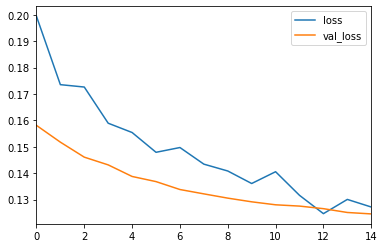

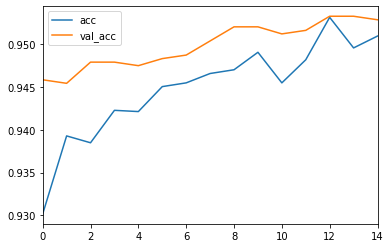

In [0]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

As this a regression problem and a final output will be numbers so we have to divide these output numbers according to the classes. So we have to determine the optimal theshold to divide. Ideally it should be 0.5 but here the data is unbalanced so accordingly the division will get affected.

In [0]:
from scipy import *

test_y = model.predict(x_val)
def compute_score_inv(threshold):
  y1 = test_y > threshold
  y1 = y1.astype(int).sum(axis=1) - 1
  y2 = y_val.sum(axis=1) - 1
  score = cohen_kappa_score(y1, y2, weights='quadratic')

  return 1 - score

simplex = scipy.optimize.minimize(compute_score_inv, 0.5, method='nelder-mead')
best_threshold = simplex['x'][0]
print(best_threshold)

0.475


Function to plot Confusion matrix

In [0]:
import itertools
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
# Evaluating the model with best weights obtained during training
def evaluate_model(x_test,y_test,model_weights):
  
  model.load_weights(model_weights)

  model.compile(loss='binary_crossentropy',optimizer= Adam(lr=0.00005),metrics=['accuracy'])

  scores = model.evaluate(x_test, y_test, verbose=1)
 
  print("Test Accuracy: %.2f%%" % (scores[1]*100))
  
  y_pred = model.predict(x_test) > 0.5
  y_pred = (y_pred.astype(int).sum(axis=1) - 1).clip(0,4)
  """
  for i in range(4):
    plt.imshow(x_test[i])
    plt.title("Predicted : {} , Actual : {}".format(y_pred[i],test_labels[i]))
    plt.show()
  """
  y_actual = (y_test.astype(int).sum(axis=1) - 1)

  cm = confusion_matrix(y_actual,y_pred)
  plot_confusion_matrix(cm,classes= np.arange(4))
   
  print(classification_report(y_actual,y_pred,target_names=['Class: 0','Class: 1','Class: 2','Class: 3','Class: 4']))

In [0]:
model_weights = '/tmp/finetunemodel.h5'

In [0]:
test_labels = np.argmax(y_test,axis=-1)

440/440 [==============================] - 4s 10ms/step
Test Accuracy: 96.05%
Confusion matrix, without normalization
[[232   2   0   0   0]
 [  6  16  14   0   1]
 [  2   8 103   6   0]
 [  0   0  11   5   1]
 [  1   1  10   5  16]]
              precision    recall  f1-score   support

    Class: 0       0.96      0.99      0.98       234
    Class: 1       0.59      0.43      0.50        37
    Class: 2       0.75      0.87      0.80       119
    Class: 3       0.31      0.29      0.30        17
    Class: 4       0.89      0.48      0.63        33

    accuracy                           0.85       440
   macro avg       0.70      0.61      0.64       440
weighted avg       0.84      0.85      0.84       440



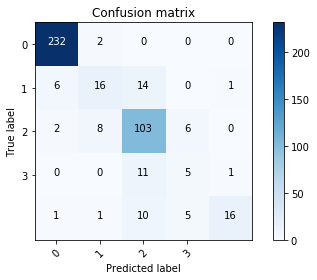

In [0]:
evaluate_model(x_test,y_test,model_weights)

Now we can call an external or new test dataset to get prediction on it with our trained Model

In [0]:
test_dir = os.path.join('/tmp/test_images/Test/')
print('total testing images:', len(os.listdir(test_dir)))

In [0]:
test_df=pd.read_csv('/content/drive/My Drive/Hardik/Test_kappa.csv') #without label column 
test_df.image[502:605] = test_df.image[502:605].apply(lambda x: x + ".jpg")

test_df.image[502:605]

In [0]:
N = test_df.shape[0]
x_test = np.empty((N, 299, 299, 3), dtype=np.uint8)

for i, image in enumerate(tqdm(test_df['image'])):
    x_test[i, :, :, :] = preprocess_image(f'/tmp/test_images/Test/{image}')